# ChinaCXRSet

Distribución del dataset:

- 336 casos de pacientes con manifestación de tuberculosis
- 326 casos normales 

Atributos 

- Género
- Edad
- Indica la anormalidad(Sano o Enfermo con Manifestación de Tuberculosis) 

Atributos finales
- Ruta de la imagen `image_name`
- Condición `condition`

Label map:
```python
labels_map = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}
```

In [6]:
import os
import random

import numpy as np
import pandas as pd

import sklearn.model_selection

In [242]:
direccion_dataset = "/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/" #Poner la dirección del dataset aquí
ruta_clinical_readings= os.path.join(direccion_dataset, "ClinicalReadings/")
ruta_cxr_png = os.path.join(direccion_dataset, "CXR_png/")
extension_cxr = "png"
extension_cr = "txt" #Extension Clinical Reading
lista_elementos_dataset = os.listdir(ruta_clinical_readings)
datos = [] #np.zeros((len(lista_elementos_dataset),), dtype=[("path", np.str_), ("genre", np.str_), ("age", "f4"), ("condition", "a10")])

for idx, elemento in enumerate(lista_elementos_dataset):
    nombre_elemento = elemento.split(".")[0]
    ruta_elemento_cxr = os.path.join(ruta_cxr_png, "{}.{}".format(nombre_elemento, extension_cxr))
    ruta_elemento_cr = os.path.join(ruta_clinical_readings, "{}.{}".format(nombre_elemento, extension_cr))
    nombre_elemento_cxr = "{}.{}".format(nombre_elemento, extension_cxr)
    with open(ruta_elemento_cr, 'r') as archivo_texto:
        datos_archivo_texto = archivo_texto.read() #Obtengo la informacion del dataset
        datos_archivo_texto = datos_archivo_texto.rstrip() #Eliminar tabulación final
        datos_archivo_texto.replace("\t", "")
        atributos_archivo = datos_archivo_texto.split('\n') #Separar por enters
        condicion_paciente = atributos_archivo[-1] #Ultimo elemento
        genero = ""
        edad = 0
        if "," in atributos_archivo[0]:
            genero_edad = atributos_archivo[0].rstrip().lstrip().split(",")
        
        else:
            genero_edad = atributos_archivo[0].rstrip().split(" ")
            #Verificar si el genero y la edad estan unidos
            if len(genero_edad) == 1:
                if genero_edad[0].find('female') == 0:
                    genero_edad.append(genero_edad[0].lstrip("female"))
                    genero_edad[0] = "female"
                elif genero_edad[0].find('male') == 0:
                    genero_edad.append(genero_edad[0].lstrip("male"))
                    genero_edad[0] = "male"
        #Eliminar los caracteres vacios
        genero_edad = [valido for valido in genero_edad if valido]

        genero, edad = genero_edad[0:2]

        if "yrs" in edad: #Convertir a int
            edad = edad.rstrip("yrs")
        elif "yr" in edad: #Convertir a int
            edad = edad.rstrip("yr")
        elif "month" in edad: #Convertir a int
            edad = edad.rstrip("month")
            edad = float(edad)/12.0
        elif "days" in edad: #Convertir a int
            edad = edad.rstrip("days")
            edad = float(edad)/365.0
        
        genero = genero.rstrip().lstrip().lower()
        if genero.find("fem")==0:
            genero = 'female'
        edad = float(edad)
    ruta_elemento_clinical_reading = os.path.join(ruta_clinical_readings)
    datos.append({"image_name":nombre_elemento_cxr, "genre": genero, "age": edad,  "condition": condicion_paciente})
dataset_china = pd.DataFrame(datos) #Convertir a formato Pandas


## Filtrar los datos

In [243]:
dataset_china.loc[dataset_china["condition"] != "normal", 'condition'] = 'tuberculosis'
dataset_china.loc[dataset_china["condition"] == "normal", 'condition'] = 0
dataset_china.loc[dataset_china["condition"] == "tuberculosis", 'condition'] = 1
#Eliminar la columna edad y genero
_ = dataset_china.pop("age")
_ = dataset_china.pop("genre")


## Crear el Dataset de tipo PyTorch

In [262]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose


class crearDatasetChinaCXRSet(Dataset):
    """
        params:
        pandas_file
    """
    def __init__(self, pandas_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pandas_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        print(img_path)
        print(image.shape)
        if self.transform:
            custom_transform = self.transform
            if image.shape[0] == 1: #Si tiene una capa, no transformar
                transform_to_grayscale = [True for transf in custom_transform.transforms if isinstance(transf, torchvision.transforms.transforms.Grayscale)]
                if transform_to_grayscale:
                    #TODO: Eliminar el objeto con su instancia
                    custom_transform = Compose(custom_transform.transforms[1:])
                image = custom_transform(image)
            else:
                image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dividir el Dataset

In [263]:
dataset_train, dataset_test = sklearn.model_selection.train_test_split(dataset_china, train_size=0.75, test_size=0.25)
dataset_test, dataset_val = sklearn.model_selection.train_test_split(dataset_test, train_size=0.6, test_size=0.4)

In [264]:
from torchvision.transforms import Resize, Grayscale #Cargar herramienta para hacer resize y grayscale
from torchvision.transforms import Compose
resize_transform = Resize((1024,1024)) #Cambiar el tamaño a 1024x1024
grayscale_transform = Grayscale(num_output_channels=1) #Convertir todas a escala de grises
transformaciones_dataset = Compose([grayscale_transform, resize_transform]) #Apila las transformaciones
train_DatasetChinaCXRSet_torch = crearDatasetChinaCXRSet(dataset_train, ruta_cxr_png, transformaciones_dataset)
test_DatasetChinaCXRSet_torch = crearDatasetChinaCXRSet(dataset_test, ruta_cxr_png, transformaciones_dataset)
val_DatasetChinaCXRSet_torch = crearDatasetChinaCXRSet(dataset_val, ruta_cxr_png, transformaciones_dataset)

In [265]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_DatasetChinaCXRSet_torch, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_DatasetChinaCXRSet_torch, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_DatasetChinaCXRSet_torch, batch_size=64, shuffle=True)

/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0059_0.png
torch.Size([1, 2947, 3000])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0224_0.png
torch.Size([1, 2978, 2988])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0175_0.png
torch.Size([1, 2009, 2205])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0613_1.png
torch.Size([1, 2672, 2546])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0478_1.png
torch.Size([1, 2365, 2556])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0536_1.png
torch.Size([1, 2533, 2396])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0424_1.png
torch.Size([1, 2944, 2980])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0065_0.png
torch.Size([1, 2945, 2996])
/media/josejacomeb/Datos1/DatasetsMédicos/ChinaSet_AllFiles/CXR_png/CHNCXR_0010_0.png
to

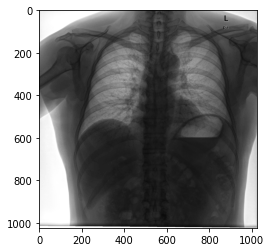

Label: 1


In [267]:
import matplotlib.pyplot as plt
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [250]:
train_dataloader.__get_item__(0)

AttributeError: 'DataLoader' object has no attribute '__get_item__'

In [25]:
dataset_val

,image_name,genre,age,condition
436,CHNCXR_0447_1.png,male,56.0,1
424,CHNCXR_0434_1.png,male,28.0,1
576,CHNCXR_0573_1.png,male,32.0,1
7,CHNCXR_0007_0.png,female,53.0,0
174,CHNCXR_0168_0.png,male,27.0,0
...,...,...,...,...
213,CHNCXR_0210_0.png,male,27.0,0
397,CHNCXR_0405_1.png,male,44.0,1
654,CHNCXR_0655_1.png,male,33.0,1
219,CHNCXR_0216_0.png,male,40.0,0


In [42]:
dataset_test

,path,genre,age,condition
550,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,female,67.0,tuberculosis
312,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,30.0,normal
583,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,25.0,tuberculosis
21,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,56.0,normal
411,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,27.0,tuberculosis
...,...,...,...,...
599,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,female,15.0,tuberculosis
216,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,43.0,normal
138,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,26.0,normal
511,/media/josejacomeb/Datos1/DatasetsMédicos/Chin...,male,63.0,tuberculosis
